# Train and test new model

Using the saved vector representations as input, i coded a simple MLP to predict the affinity scores. After testing I will apply the same evaluation metrics as for the tankbind model and then compare the 2. Hopefully we where able to improve the error.

In [1]:
import os
# Set which GPU to use (here, GPU 2) by setting the CUDA_VISIBLE_DEVICES environment variable 
# (important if executed on server, check which GPU is available)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
gpu_id = device.index
print('Gpu name:', torch.cuda.get_device_name(gpu_id))
print('Memory allocated:', round(torch.cuda.memory_allocated(gpu_id) / (1024 ** 3),2), 'GB')
print('Memory cached:', round(torch.cuda.memory_reserved(gpu_id) / (1024 ** 3),2), 'GB')

Gpu name: Tesla P40
Memory allocated: 0.0 GB
Memory cached: 0.0 GB


In [3]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import torchmetrics
import pandas as pd
from tqdm.notebook import tqdm
import itertools
import matplotlib.pyplot as plt

## Load data (vector representations)

In [4]:
data = torch.load("vector_representations/vector_representations.pt")
labels = torch.load("vector_representations/labels.pt")
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: torch.Size([105634, 128])
Labels shape: torch.Size([105634])


In [117]:
# split into training and test sets
X, X_test, y, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=42) # 0.12 to get around 10_000 samples in validation set

print("Training set size:  ", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:      ", len(X_test))

Training set size:   74366
Validation set size: 10141
Test set size:       21127


### Normalize the data

Why one might skip normalization here:

- If the vectors are already coming from a pretrained model (self_dockt.pt) where the representation is internally normalized or bounde, further normalization now may not change much.

If time permits try training with and without normalization and see how it affects the perfomance of the model.

**Model performs significantly better with normalized data**

In [118]:
# fit a scaler to only the training data, then transform the entire dataset with that scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.numpy())

# normalize training set
X_train = torch.tensor(X_train, dtype=torch.float32)

# normalize validation & test set
X_val = torch.tensor(scaler.transform(X_val.numpy()), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test.numpy()), dtype=torch.float32)

### Create dataloaders

In [119]:
BATCH_SIZE = 64 # set batchsize (depending on GPU memory it can be 64-256 or higher...) 

# Note: for this batchsize the GPU had 24GB RAM and could be set higher for this memory size

In [120]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of batches in train loader:      {len(train_loader)},  with n samples: {len(train_loader.dataset)}")
print(f"Number of batches in validation loader:  {len(val_loader)},  with n samples: {len(val_loader.dataset)}")
print(f"Number of batches in test loader:        {len(test_loader)},  with n samples: {len(test_loader.dataset)}")

Number of batches in train loader:      1162,  with n samples: 74366
Number of batches in validation loader:  159,  with n samples: 10141
Number of batches in test loader:        331,  with n samples: 21127


# Models

## MLP-Model

In [121]:
class AffinityPredMLP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, output_dim=1):
        super(AffinityPredMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim) # output_dim is 1 for regression tasks
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize the model and move to the appropriate device
# model = AffinityPredMLP().to(device)
# model = AffinityPredMLP(input_dim=128, hidden_dim=1024, output_dim=1).to(device)

### Functions for training and evaluation

In [122]:
# Trainin Function (process per epoch)
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).float()  # Ensure y is float for regression

        optimizer.zero_grad()

        preds = model(x)

        loss = criterion(preds.squeeze(), y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(dataloader.dataset)

# evaluation function (for validation and test)
def evaluate(model, dataloader, criterion, type='val'):
    model.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device).float()
            preds = model(x)
            loss = criterion(preds.squeeze(), y)
            total_loss += loss.item() * x.size(0)

            if type == 'test': # Uncomment to if you want the predictions and true labels for test set
                predictions.append(preds.detach().cpu().numpy())
                
    if type == 'test':
        return total_loss / len(dataloader.dataset), np.concatenate(predictions)

    return total_loss / len(dataloader.dataset)


### GridSearch for optimal parameter settings

In [ ]:
def grid_search(train_loader, val_loader, param_grid, device):
    best_params = None
    best_score = float('inf')

    keys, vals = zip(*param_grid.items())
    for v in itertools.product(*vals):
        params = dict(zip(keys, v))

        # initialize model with current parameters
        model = AffinityPredMLP(input_dim=128, hidden_dim=params['hidden_dim'], output_dim=1).to(device)

        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'adamw':
            optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, weight_decay=params['weight_decay'])

        # train & evaluate
        for epoch in range(1, EPOCHS + 1):
            train_loss = train_epoch(model, train_loader, optimizer, criterion)
            val_loss = evaluate(model, val_loader, criterion)

        print(f"Params: {params}, Val MSE: {val_loss:.4f}")
        if val_loss < best_score:
            best_score = val_loss
            best_params = params
            torch.save(model.state_dict(), "model/best_model_grid_search.pt")

        
    print(f"Best parameters: {best_params}, Best validation MSE: {best_score:.4f}")
    return best_params

In [ ]:
param_grid = {
    'hidden_dim': [256, 512],
    'optimizer': ['adam', 'adamw'],
    'lr': [1e-3, 1e-4, 5e-3, 5e-4],
    'weight_decay': [0.0, 1e-5, 1e-4]
}

best_params = grid_search(train_loader, val_loader, param_grid, device)

## Training loop

**Set hyperparmeters:**

In [123]:
# hyperparameters
h_dim = 512
model = AffinityPredMLP(input_dim=128, hidden_dim=h_dim, output_dim=1).to(device)

EPOCHS = 500  # 100/200 would also be enough, 500 might lead to overfitting
LEARNING_RATE = 5e-4

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Adam optimizer with weight decay for regularization
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks

best_val_loss = float('inf') # for best model selection/saving

In [ ]:
# training loop
train_losses, val_losses = [], []

for epoch in tqdm(range(1, EPOCHS + 1), desc="Training Progress"):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "model/mlp_model.pt")
        # print("Best model saved!")

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50/500, Train Loss: 0.4730, Val Loss: 0.5272
Epoch 100/500, Train Loss: 0.3911, Val Loss: 0.5149
Epoch 150/500, Train Loss: 0.3412, Val Loss: 0.5099
Epoch 200/500, Train Loss: 0.3059, Val Loss: 0.5129
Epoch 250/500, Train Loss: 0.2813, Val Loss: 0.5130
Epoch 300/500, Train Loss: 0.2618, Val Loss: 0.5113
Epoch 350/500, Train Loss: 0.2466, Val Loss: 0.5101
Epoch 400/500, Train Loss: 0.2314, Val Loss: 0.5210
Epoch 450/500, Train Loss: 0.2224, Val Loss: 0.5239
Epoch 500/500, Train Loss: 0.2132, Val Loss: 0.5282


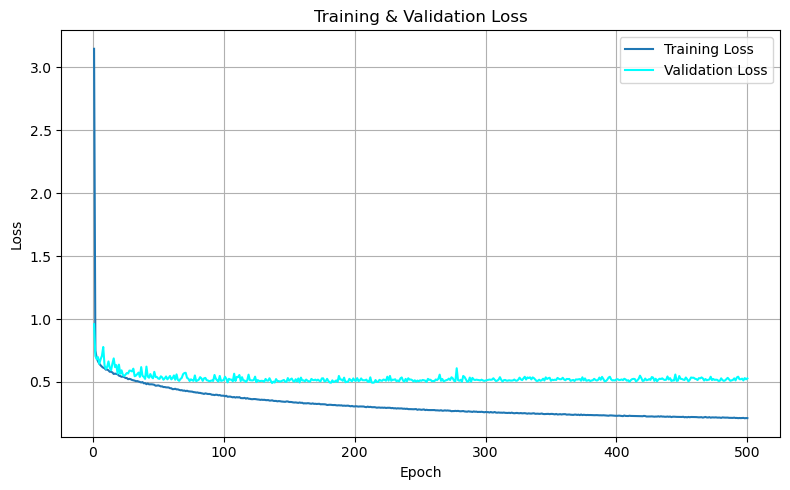

In [125]:
# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Inference - Get predictions from the MLP model and reshape them 

In [152]:
model_mlp = AffinityPredMLP(input_dim=128, hidden_dim=h_dim, output_dim=1).to(device)
model_mlp.load_state_dict(torch.load("model/mlp_model.pt"))

test_loss, preds_mlp = evaluate(model_mlp, test_loader, criterion, 'test')
print(f"Test MSE: {test_loss:.4f}")

Test MSE: 0.4663


In [153]:
print("Predictions shape:", preds_mlp.shape)
print("First 5 predictions:", preds_mlp[:5])

# change shape of predictions to match true labels
preds_mlp = preds_mlp.squeeze()
print("Final Predictions shape:", preds_mlp.shape)

Predictions shape: (21127, 1)
First 5 predictions: [[13.321975]
 [11.355316]
 [11.945322]
 [12.371895]
 [11.494199]]
Final Predictions shape: (21127,)


## XGBoost

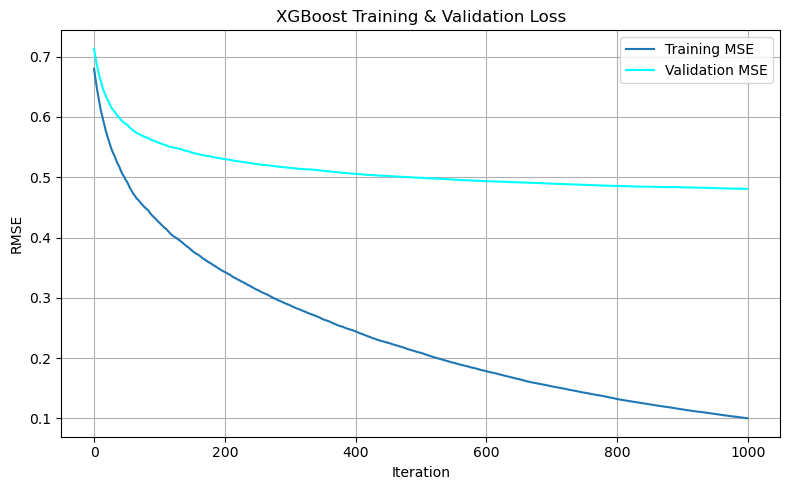

Test RMSE for XGBoost: 0.4622


In [20]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=1000,  # Number of boosting iterations
    learning_rate=0.05,  # Learning rate
    max_depth=8,  # Maximum depth of the tree
    subsample=0.8,  # Fraction of samples to use for each tree
    colsample_bytree=0.8,  # Fraction of features to use for each tree
    eval_metric='rmse',  # Evaluation metric
    tree_method='hist',  # Use GPU for training
    device=device.type,  # Use the same device as the model
)

# model_xgb.fit(X_train.numpy(), y_train.numpy(), eval_set=[(X_val.numpy(), y_val.numpy())])

model_xgb.fit(
    X_train.numpy(), 
    y_train.numpy(), 
    eval_set=[(X_train.numpy(), y_train.numpy()), (X_val.numpy(), y_val.numpy())], 
    verbose=False
)

results = model_xgb.evals_result()

# turn rmse scores into mse scores
for key in results.keys():
    results[key]['mse'] = np.square(results[key]['rmse'])

# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(results['validation_0']['mse'], label='Training MSE', color='red')
plt.plot(results['validation_1']['mse'], label='Validation MSE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# evaluate predictions
preds_xgb = model_xgb.predict(X_test.numpy())
test_loss_xgb = np.mean((preds_xgb - y_test.numpy()) **2)
print(f"Test RMSE for XGBoost: {test_loss_xgb:.4f}")

# save model
torch.save(model_xgb, "model/xgb_model.pt")

## LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 74366, number of used features: 128
[LightGBM] [Info] Start training from score 11.717098


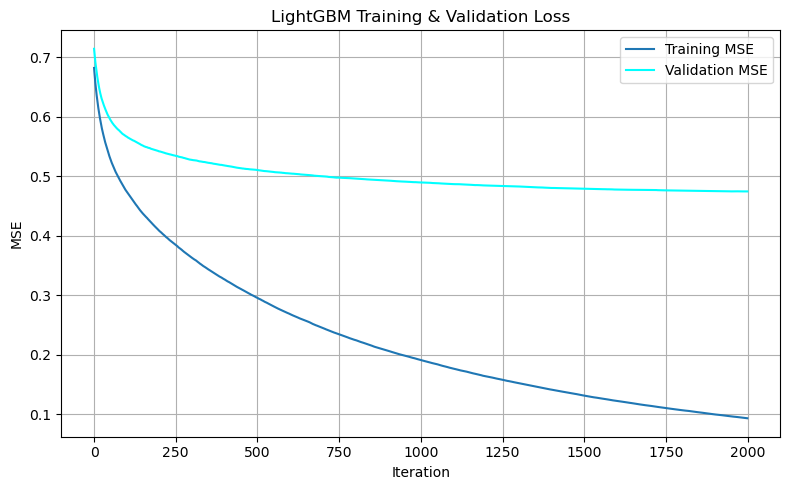

Test MSE for LightGBM: 0.4583


In [17]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(
    num_leaves=64,  # Number of leaves in one tree
    n_estimators=2000, #1000 # Number of boosting iterations
    learning_rate=0.05,  # Learning rate
    subsample=0.8,  # Fraction of samples to use for each tree
    colsample_bytree=0.8,  # Fraction of features to use for each tree
)

# model_lgb.fit(X_train.numpy(), y_train.numpy(), eval_set=[(X_val.numpy(), y_val.numpy())], eval_metric='mse')
eval_results = {}

model_lgb.fit(
    X_train.numpy(), 
    y_train.numpy(), 
    eval_set=[(X_train.numpy(), y_train.numpy()),(X_val.numpy(), y_val.numpy())], 
    eval_metric='mse', callbacks=[lgb.record_evaluation(eval_results)], 
    )

# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(eval_results['valid_0']['l2'], label='Training MSE', color='green') # the training set is the first one in eval_results
plt.plot(eval_results['valid_1']['l2'], label='Validation MSE', color='lime') # the validation set is the second one in eval_results
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('LightGBM Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# evaluate predictions
preds_lgb = model_lgb.predict(X_test.numpy())
test_loss_lgb = np.mean((preds_lgb - y_test.numpy()) ** 2)
print(f"Test MSE for LightGBM: {test_loss_lgb:.4f}")

# save model
torch.save(model_lgb, "model/lgb_model.pt")

# Evaluation

**Mean squared error, mean absolute error & r2-score:**

In [21]:
def eval_metrics(targets, predictions):
    mse = torchmetrics.functional.mean_squared_error(torch.tensor(predictions), torch.tensor(targets))
    mae = torchmetrics.functional.mean_absolute_error(torch.tensor(predictions), torch.tensor(targets))
    r2 = torchmetrics.functional.r2_score(torch.tensor(predictions), torch.tensor(targets))
    return mse.item(), mae.item(), r2.item()

**Concordance index:**

In [173]:
def concordance_idx(y_true, y_pred):
    # 1. Convert inputs to NumPy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 2. Sort by predicted values
    order = np.argsort(y_pred)
    y_true = y_true[order]

    # 3. Find unique labels and group sizes
    unique_labels, inverse = np.unique(y_true, return_inverse=True)
    counts = np.bincount(inverse)  # number of samples per unique label

    # print(f"Found {len(unique_labels)} unique labels")

    # 4. Compute cumulative counts
    cum_counts = np.cumsum(counts)  # prefix sum for fast pair counting

    concordant = 0
    total_pairs = 0

    # 5. Iterate over label groups
    for i, count_i in enumerate(counts):
        # Total pairs with higher labels (since sorted by prediction, no pair expansion)
        higher = cum_counts[-1] - cum_counts[i]
        total_pairs += count_i * higher

        # Since it is sorted by prediction, all these pairs are concordant
        concordant += count_i * higher

    c_index = concordant / total_pairs if total_pairs > 0 else np.nan

    return c_index


In [174]:
# MLP predictions
mse_mlp, mae_mlp, r2_mlp = eval_metrics(y_test.cpu().numpy(), preds_mlp)
c_idx_mlp = concordance_idx(y_test.cpu().numpy(), preds_mlp)
print(f"MLP      -> MSE: {mse_mlp:.4f}, MAE: {mae_mlp:.4f}, R2: {r2_mlp:.4f}, Concordance Index: {c_idx_mlp:.4f}")

# XGBoost predictions
mse_xgb, mae_xgb, r2_xgb = eval_metrics(y_test.cpu().numpy(), preds_xgb)
c_idx_xgb = concordance_idx(y_test.cpu().numpy(), preds_xgb)
print(f"XGBoost  -> MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}, Concordance Index: {c_idx_xgb:.4f}")

# LightGBM predictions
mse_lgb, mae_lgb, r2_lgb = eval_metrics(y_test.cpu().numpy(), preds_lgb)
c_idx_lgb = concordance_idx(y_test.cpu().numpy(), preds_lgb)
print(f"LightGBM -> MSE: {mse_lgb:.4f}, MAE: {mae_lgb:.4f}, R2: {r2_lgb:.4f}, Concordance Index: {c_idx_lgb:.4f}")

MLP      -> MSE: 0.4663, MAE: 0.4743, R2: 0.3426, Concordance Index: 1.0000
XGBoost  -> MSE: 0.4622, MAE: 0.4584, R2: 0.3484, Concordance Index: 1.0000
LightGBM -> MSE: 0.4583, MAE: 0.4555, R2: 0.3539, Concordance Index: 1.0000


### Prediction stacking

**All 3 model predictions:**

In [131]:
preds_avg = (preds_mlp + preds_lgb + preds_xgb) / 3

mse_avg, mae_avg, r2_avg = eval_metrics(y_test.cpu().numpy(), preds_avg)
c_idx_avg = concordance_idx(y_test.cpu().numpy(), preds_avg)

print(f"Average -> MSE: {mse_avg:.4f}, MAE: {mae_avg:.4f}, R2: {r2_avg:.4f}, Concordance Index: {c_idx_avg:.4f}")

Average -> MSE: 0.4318, MAE: 0.4427, R2: 0.3913, Concordance Index: 1.0000


**MLP + XGBoost:**

In [132]:
preds_avg_2 = (preds_mlp + preds_xgb) / 2

mse_avg_2, mae_avg_2, r2_avg_2 = eval_metrics(y_test.cpu().numpy(), preds_avg_2)
c_idx_avg_2 = concordance_idx(y_test.cpu().numpy(), preds_avg_2)

print(f"Average -> MSE: {mse_avg_2:.4f}, MAE: {mae_avg_2:.4f}, R2: {r2_avg_2:.4f}, Concordance Index: {c_idx_avg_2:.4f}")

Average -> MSE: 0.4329, MAE: 0.4464, R2: 0.3897, Concordance Index: 1.0000


**MLP + LightGBM:**

In [134]:
preds_avg_3 = (preds_mlp + preds_lgb) / 2

mse_avg_3, mae_avg_3, r2_avg_3 = eval_metrics(y_test.cpu().numpy(), preds_avg_3)
c_idx_avg_3 = concordance_idx(y_test.cpu().numpy(), preds_avg_3)

print(f"Average -> MSE: {mse_avg_3:.4f}, MAE: {mae_avg_3:.4f}, R2: {r2_avg_3:.4f}, Concordance Index: {c_idx_avg_3:.4f}")

Average -> MSE: 0.4312, MAE: 0.4450, R2: 0.3922, Concordance Index: 1.0000


**XGBoost + LightGBM:**

In [135]:
preds_avg_4 = (preds_lgb + preds_xgb) / 2

mse_avg_4, mae_avg_4, r2_avg_4 = eval_metrics(y_test.cpu().numpy(), preds_avg_4)
c_idx_avg_4 = concordance_idx(y_test.cpu().numpy(), preds_avg_4)

print(f"Average -> MSE: {mse_avg_4:.4f}, MAE: {mae_avg_4:.4f}, R2: {r2_avg_4:.4f}, Concordance Index: {c_idx_avg_4:.4f}")

Average -> MSE: 0.4541, MAE: 0.4525, R2: 0.3598, Concordance Index: 1.0000


# Plottting code

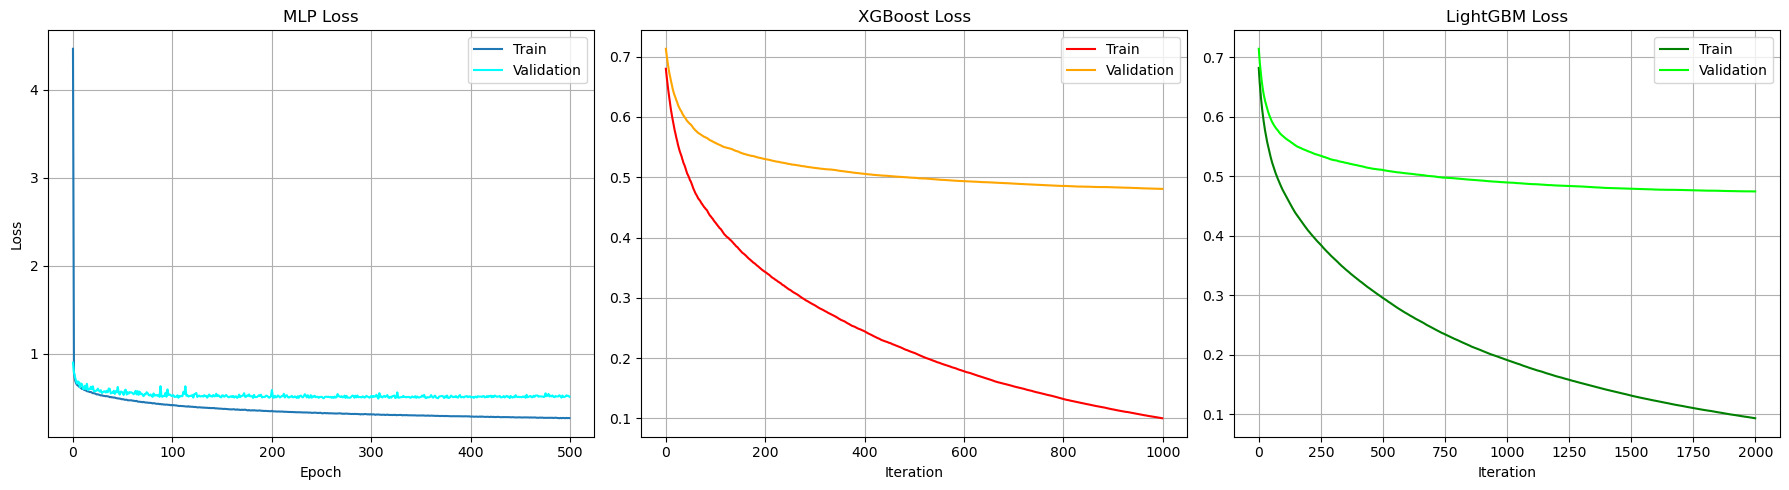

In [ ]:
# Prepare x-axes
mlp_x = range(len(train_losses))
mlp_x_val = range(len(val_losses))
xgb_x = range(len(results['validation_0']['mse']))
xgb_x_val = range(len(results['validation_1']['mse']))
lgbm_x = range(len(eval_results['valid_0']['l2']))
lgbm_x_val = range(len(eval_results['valid_1']['l2']))

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# MLP
axs[0].plot(mlp_x, train_losses, label='Train')
axs[0].plot(mlp_x_val, val_losses, label='Validation', color='cyan')
axs[0].set_title('MLP Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# XGBoost
axs[1].plot(xgb_x, results['validation_0']['mse'], label='Train', color='red')
axs[1].plot(xgb_x_val, results['validation_1']['mse'], label='Validation', color='orange')
axs[1].set_title('XGBoost Loss')
axs[1].set_xlabel('Iteration')
axs[1].legend()
axs[1].grid(True)

# LightGBM
axs[2].plot(lgbm_x, eval_results['valid_0']['l2'], label='Train', color='green')
axs[2].plot(lgbm_x_val, eval_results['valid_1']['l2'], label='Validation', color='lime')
axs[2].set_title('LightGBM Loss')
axs[2].set_xlabel('Iteration')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

### Plotting functions:

In [182]:
def plot_loss_curves(train_xs, val_xs, train_losses, val_losses, x_label='Epoch/Iteration'):
    """
    Plots training and validation loss curves for MLP, XGBoost, and LightGBM.
    Args:
        train_xs: tuple of (mlp_x, xgb_x, lgbm_x) for training losses
        val_xs: tuple of (mlp_x_val, xgb_x_val, lgbm_x_val) for validation losses
        train_losses: tuple of (mlp_train, xgb_train, lgbm_train) loss values
        val_losses: tuple of (mlp_val, xgb_val, lgbm_val) loss values
        x_label: label for the x-axis
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Training losses
    axs[0].plot(train_xs[0], train_losses[0], label='MLP')
    axs[0].plot(train_xs[1], train_losses[1], label='XGBoost', color='red')
    axs[0].plot(train_xs[2], train_losses[2], label='LightGBM', color='lime')
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Validation losses
    axs[1].plot(val_xs[0], val_losses[0], label='MLP')
    axs[1].plot(val_xs[1], val_losses[1], label='XGBoost', color='red')
    axs[1].plot(val_xs[2], val_losses[2], label='LightGBM', color='lime')
    axs[1].set_xlabel(x_label)
    axs[1].set_title('Validation Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


def plot_model_metrics(model_names, metrics, bar_colors=None, ylim=(0, 1.2)):
    """
    Plots grouped barplots for model metrics.
    Args:
        model_names: list of model names (x-axis labels)
        metrics: list of lists/arrays, each containing metric values for the models (shape: n_metrics x n_models)
        metric_names: list of metric names (for subplot titles/y-labels)
        bar_colors: list of colors for the bars (optional)
        ylim: tuple for y-axis limits (default (0, 1.2))
    """
    metric_names = ['MSE', 'MAE', 'R2', 'Concordance Index']

    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    if len(metrics) == 1:
        axs = [axs]

    for i, ax in enumerate(axs):
        bars = ax.bar(model_names, metrics[i], color=bar_colors, width=0.5)
        ax.set_title(metric_names[i])
        ax.set_ylabel(metric_names[i])
        ax.set_xticklabels(model_names, rotation=20)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        if ylim:
            ax.set_ylim(*ylim)

        # Add value labels
        for bar, value in zip(bars, metrics[i]):
            height = bar.get_height()
            if metric_names[i] in ['MSE', 'MAE']:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{value:.3f}', ha='center', va='bottom', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

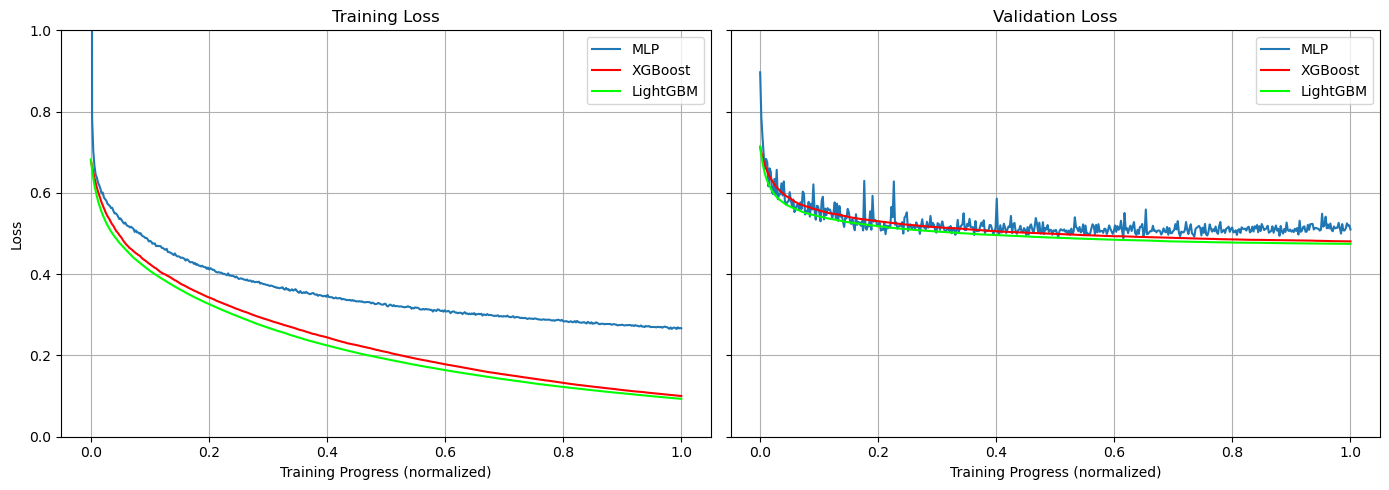

In [ ]:
# Normed loss curve comparison

# Prepare x-axes
train_xs = (np.linspace(0, 1, len(train_losses)), np.linspace(0, 1, len(results['validation_0']['mse'])), np.linspace(0, 1, len(eval_results['valid_0']['l2']))) # (mlp_x, xgb_x, lgbm_x)
val_xs = (np.linspace(0, 1, len(val_losses)), np.linspace(0, 1, len(results['validation_1']['mse'])), np.linspace(0, 1, len(eval_results['valid_1']['l2']))) # (mlp_x_val, xgb_x_val, lgbm_x_val)

plot_loss_curves(
    train_xs, val_xs, 
    (train_losses, results['validation_0']['mse'], eval_results['valid_0']['l2']), 
    (val_losses, results['validation_1']['mse'], eval_results['valid_1']['l2']), 
    x_label='Training Progress (normalized)'
)


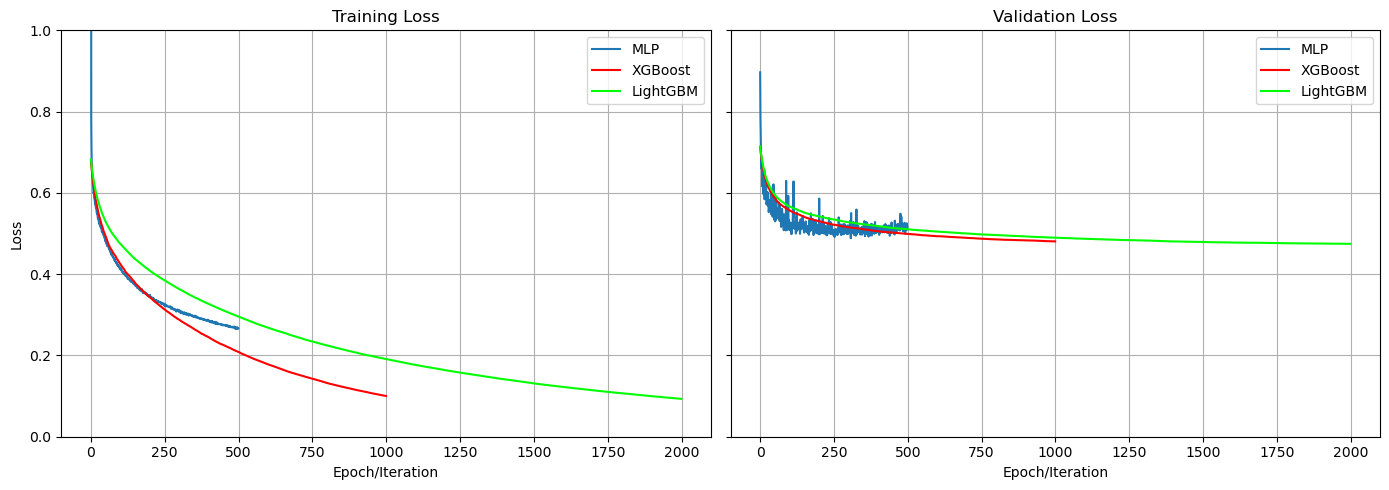

In [97]:
# Unnormed loss curve comparison

# Prepare x-axes
train_xs = (range(len(train_losses)), range(len(results['validation_0']['mse'])), range(len(eval_results['valid_0']['l2'])))  # (mlp_x, xgb_x, lgbm_x)
val_xs = (range(len(val_losses)), range(len(results['validation_1']['mse'])), range(len(eval_results['valid_1']['l2'])))  # (mlp_x_val, xgb_x_val, lgbm_x_val)

plot_loss_curves(
    train_xs, val_xs,
    (train_losses, results['validation_0']['mse'], eval_results['valid_0']['l2']),
    (val_losses, results['validation_1']['mse'], eval_results['valid_1']['l2']),
)

**Block diagramms with eval metrics**

/tmp/ipykernel_1771716/1750698202.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=20)


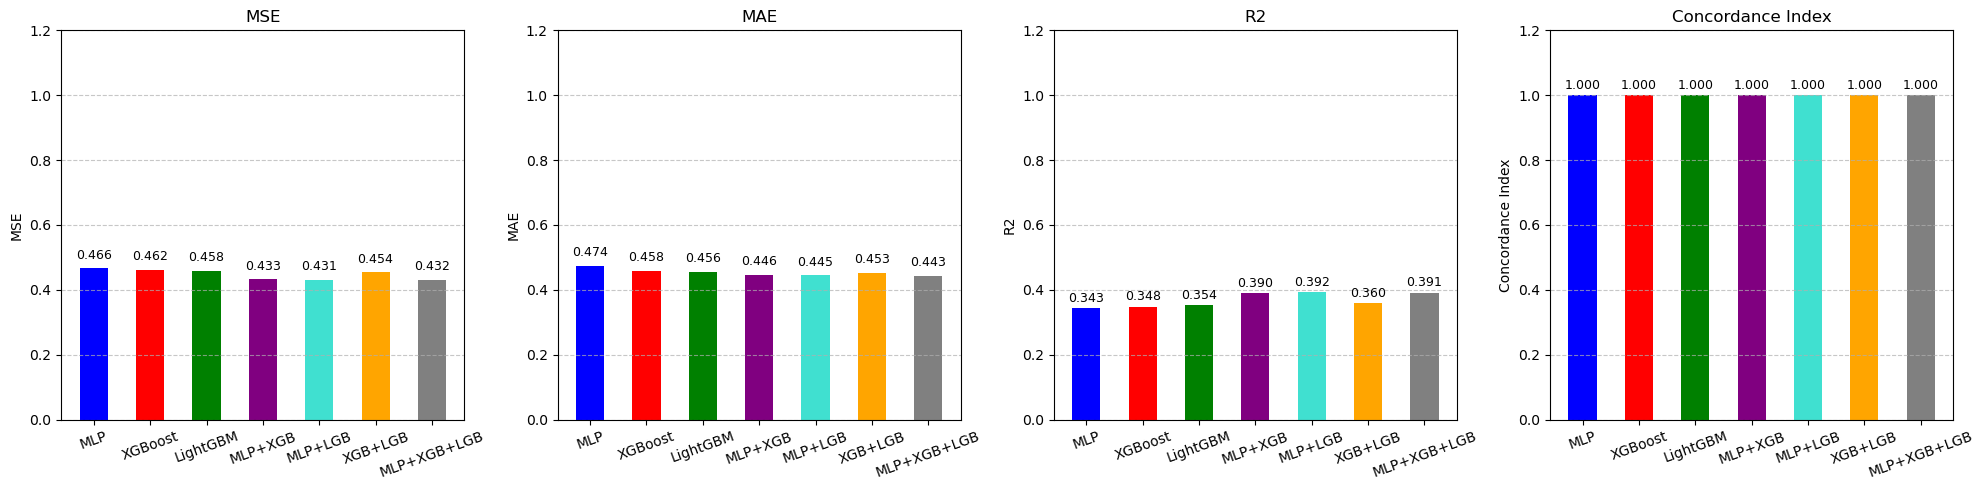

In [136]:
model_names = ['MLP', 'XGBoost', 'LightGBM', 'MLP+XGB', 'MLP+LGB', 'XGB+LGB', 'MLP+XGB+LGB']

bar_colors = ['blue', 'red', 'green', 'purple', 'turquoise', 'orange', 'gray']

mse_values = [mse_mlp, mse_xgb, mse_lgb, mse_avg_2, mse_avg_3, mse_avg_4, mse_avg]
mae_values = [mae_mlp, mae_xgb, mae_lgb, mae_avg_2, mae_avg_3, mae_avg_4, mae_avg]
r2_values = [r2_mlp, r2_xgb, r2_lgb, r2_avg_2, r2_avg_3, r2_avg_4, r2_avg]
cidx_values = [c_idx_mlp, c_idx_xgb, c_idx_lgb, c_idx_avg_2, c_idx_avg_3, c_idx_avg_4, c_idx_avg]

metrics = [mse_values, mae_values, r2_values, cidx_values]

plot_model_metrics(model_names, metrics, bar_colors=bar_colors)

/tmp/ipykernel_1771716/1750698202.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=20)


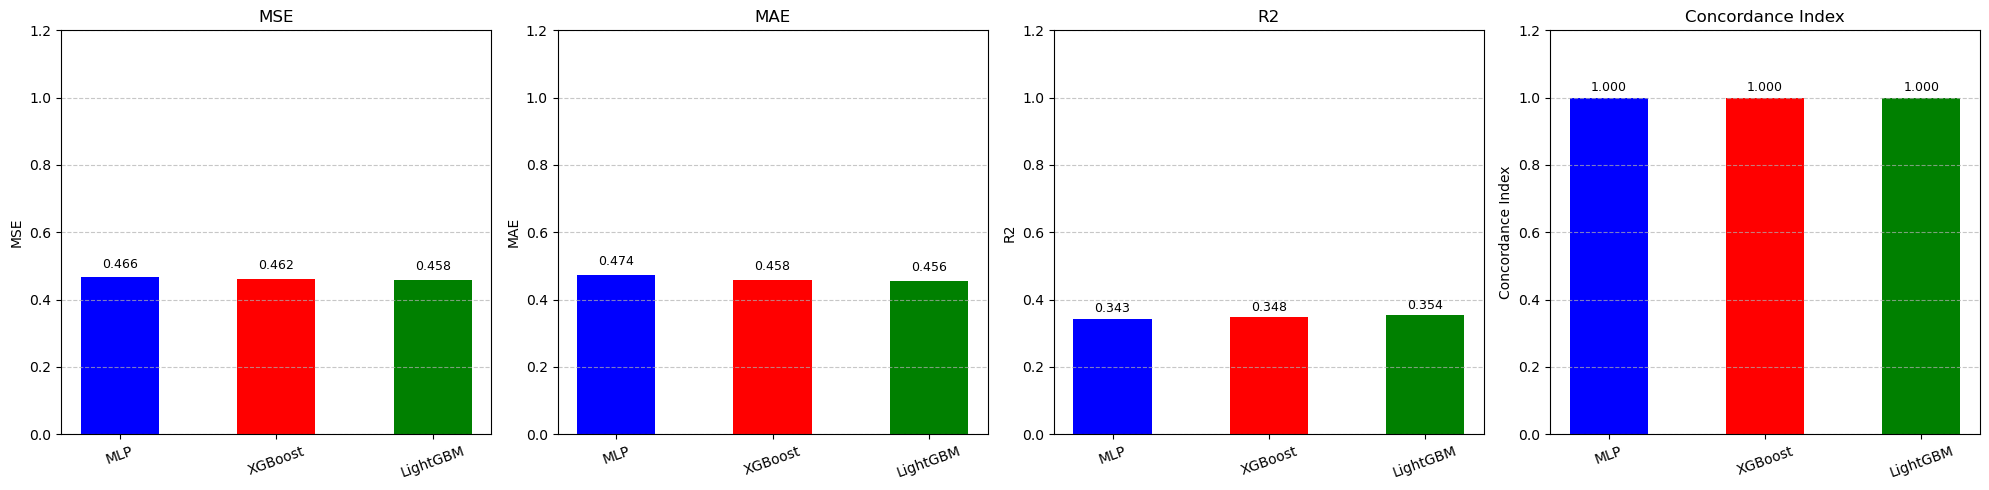

In [139]:
model_names = ['MLP', 'XGBoost', 'LightGBM']

bar_colors = ['blue', 'red', 'green']

mse_values = [mse_mlp, mse_xgb, mse_lgb]
mae_values = [mae_mlp, mae_xgb, mae_lgb]
r2_values = [r2_mlp, r2_xgb, r2_lgb]
cidx_values = [c_idx_mlp, c_idx_xgb, c_idx_lgb]

metrics = [mse_values, mae_values, r2_values, cidx_values]

plot_model_metrics(model_names, metrics, bar_colors=bar_colors)

/tmp/ipykernel_1771716/1750698202.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=20)


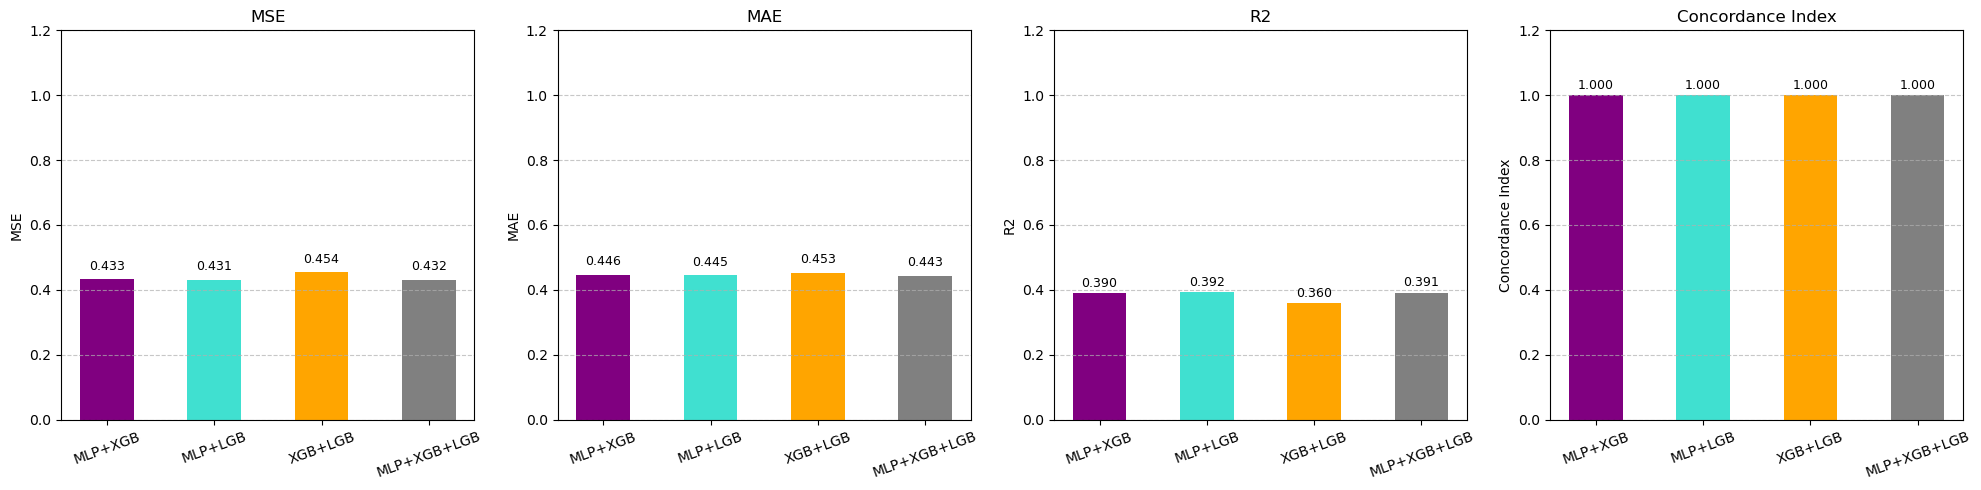

In [140]:
model_names = ['MLP+XGB', 'MLP+LGB', 'XGB+LGB', 'MLP+XGB+LGB']

bar_colors = ['purple', 'turquoise', 'orange', 'gray']

mse_values = [mse_avg_2, mse_avg_3, mse_avg_4, mse_avg]
mae_values = [mae_avg_2, mae_avg_3, mae_avg_4, mae_avg]
r2_values = [r2_avg_2, r2_avg_3, r2_avg_4, r2_avg]
cidx_values = [c_idx_avg_2, c_idx_avg_3, c_idx_avg_4, c_idx_avg]

metrics = [mse_values, mae_values, r2_values, cidx_values]

plot_model_metrics(model_names, metrics, bar_colors=bar_colors)

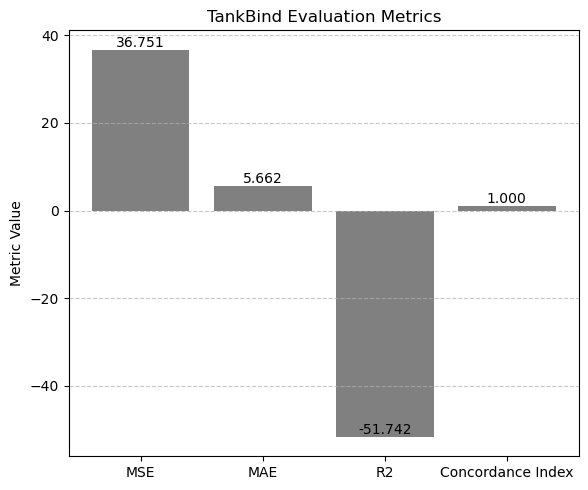

In [ ]:
# TankBind metrics
tank_metrics = [36.7511, 5.6623, -51.7421, 1.0000]
metric_names = ['MSE', 'MAE', 'R2', 'Concordance Index']

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(metric_names, tank_metrics, color=['gray', 'gray', 'gray', 'gray'])
ax.set_title('TankBind Evaluation Metrics')
ax.set_ylabel('Metric Value')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar, value in zip(bars, tank_metrics):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1771716/3950937138.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=20)


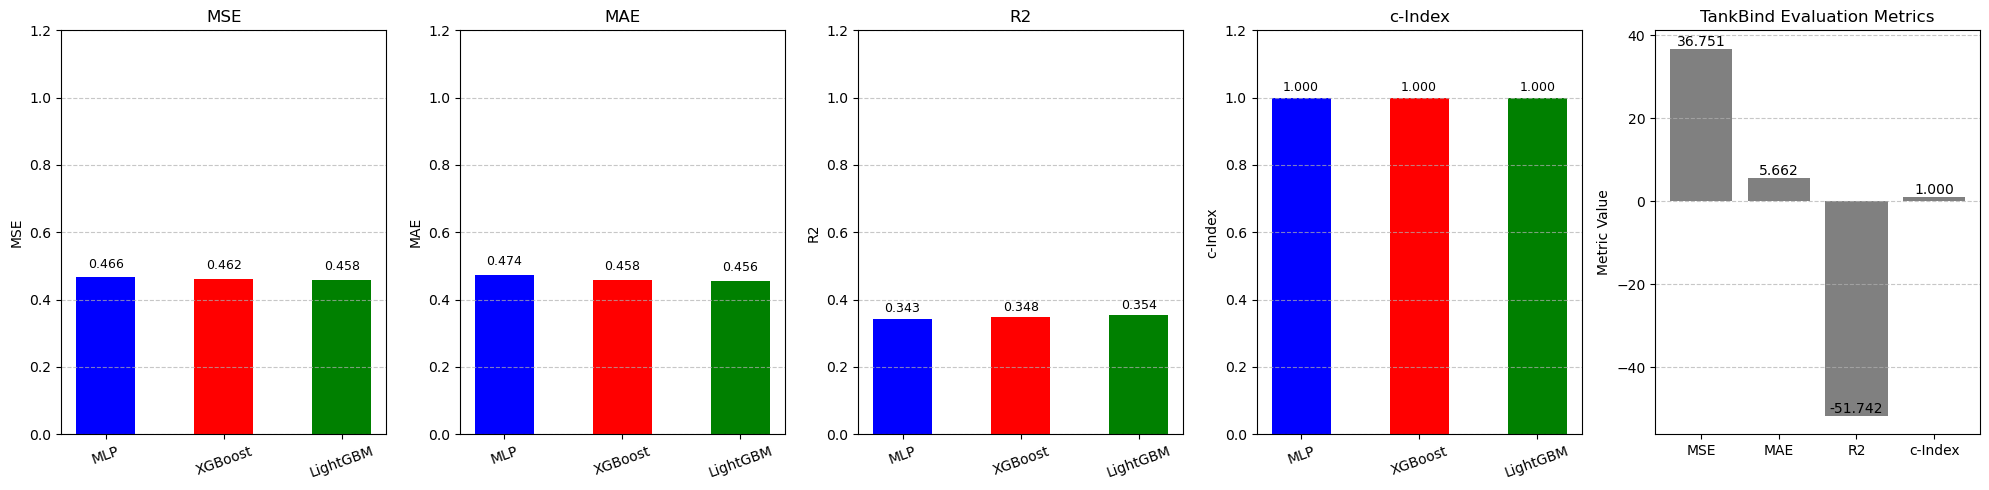

/tmp/ipykernel_1771716/1212363644.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=20)


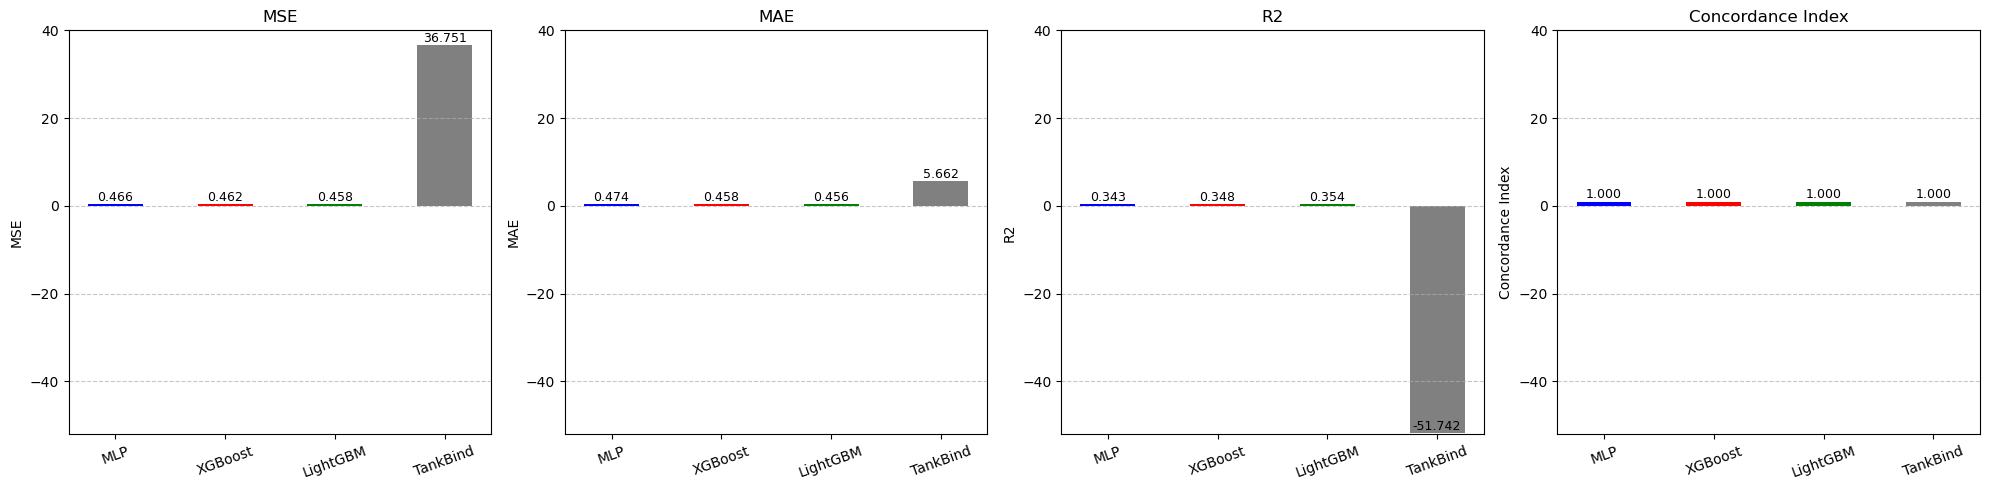

In [185]:
model_names = ['MLP', 'XGBoost', 'LightGBM']
mse_values = [mse_mlp, mse_xgb, mse_lgb]
mae_values = [mae_mlp, mae_xgb, mae_lgb]
r2_values = [r2_mlp, r2_xgb, r2_lgb]
cidx_values = [c_idx_mlp, c_idx_xgb, c_idx_lgb]

metrics = [mse_values, mae_values, r2_values, cidx_values]
metric_names = ['MSE', 'MAE', 'R2', 'c-Index']

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

bar_colors = ['blue', 'red', 'green']

for i, ax in enumerate(axs):
    if i == 4:
        bars = ax.bar(metric_names, tank_metrics, color=['gray', 'gray', 'gray', 'gray'])
        ax.set_title('TankBind Evaluation Metrics')
        ax.set_ylabel('Metric Value')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        for bar, value in zip(bars, tank_metrics):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    else:
        bars = ax.bar(model_names, metrics[i], color=bar_colors, width=0.5)
        ax.set_title(metric_names[i])
        ax.set_ylabel(metric_names[i])
        ax.set_xticklabels(model_names, rotation=20)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.2)

        # Add value labels
        for bar, value in zip(bars, metrics[i]):
            height = bar.get_height()
            if metric_names[i] in ['MSE', 'MAE']:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{value:.3f}', ha='center', va='bottom', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

model_names_t, mse_vals_t, mae_vals_t, r2_vals_t, cidx_vals_t = model_names.copy(), mse_values.copy(), mae_values.copy(), r2_values.copy(), cidx_values.copy()
model_names_t.append('TankBind')
mse_vals_t.append(tank_metrics[0])
mae_vals_t.append(tank_metrics[1])
r2_vals_t.append(tank_metrics[2])
cidx_vals_t.append(tank_metrics[3])

metrics_t = [mse_vals_t, mae_vals_t, r2_vals_t, cidx_vals_t]

plot_model_metrics(model_names_t, metrics_t, bar_colors=['blue', 'red', 'green', 'gray'], ylim=(-52, 40))